In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from tqdm import tqdm
import cv2
from PIL import Image
from skimage import exposure
from skimage.transform import resize
import scipy
import time
from statistics import mean
import tensorflow as tf
import keras as ke
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tensorflow.keras.layers import Input
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
from PIL import Image
import cv2
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spr-x-ray-age/sample_submission_age.csv
/kaggle/input/spr-x-ray-age/train_age.csv
/kaggle/input/spr-x-ray-age/kaggle/kaggle/test/005084.png
/kaggle/input/spr-x-ray-age/kaggle/kaggle/test/003065.png
/kaggle/input/spr-x-ray-age/kaggle/kaggle/test/010841.png
/kaggle/input/spr-x-ray-age/kaggle/kaggle/test/008174.png
/kaggle/input/spr-x-ray-age/kaggle/kaggle/test/003741.png
/kaggle/input/spr-x-ray-age/kaggle/kaggle/test/010373.png
/kaggle/input/spr-x-ray-age/kaggle/kaggle/test/004725.png
/kaggle/input/spr-x-ray-age/kaggle/kaggle/test/001183.png
/kaggle/input/spr-x-ray-age/kaggle/kaggle/test/005660.png
/kaggle/input/spr-x-ray-age/kaggle/kaggle/test/007355.png
/kaggle/input/spr-x-ray-age/kaggle/kaggle/test/003244.png
/kaggle/input/spr-x-ray-age/kaggle/kaggle/test/002594.png
/kaggle/input/spr-x-ray-age/kaggle/kaggle/test/011285.png
/kaggle/input/spr-x-ray-age/kaggle/kaggle/test/001703.png
/kaggle/input/spr-x-ray-age/kaggle/kaggle/test/008370.png
/kaggle/input/spr-x-ray-age/kaggle

In [3]:
Tabela_treino = pd.read_csv('/kaggle/input/spr-x-ray-age/train_age.csv',sep = ',',engine = 'python')
display(Tabela_treino)

,imageId,age
0,0,89.0
1,1,72.0
2,2,25.0
3,3,68.0
4,4,37.0
...,...,...
10697,10697,79.0
10698,10698,67.0
10699,10699,66.0
10700,10700,78.0


In [4]:
nlin = np.shape(Tabela_treino)[0]   #numero de linhas da minha tabela do excel
hhh = []
tamy = []

for i in tqdm(range(0,nlin)):
    imageID = Tabela_treino['imageId'].iloc[i]      #pega o valor do imageID de cada linha 
    file_path = ("/kaggle/input/spr-x-ray-age/kaggle/kaggle/train/"  + str(imageID).zfill(6) + ".png")
    img = cv2.imread(file_path) #aplica o numero do imageID pra buscar a imagem no diretório com o mesmo numero
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.merge((img,img,img))
    img = cv2.resize(img, (100,100), interpolation = cv2.INTER_AREA)
    img = np.array(img)/255
    hhh.append(img)
    tamy.append(Tabela_treino['age'].iloc[i])
tamy = np.array(tamy)
    
    

100%|██████████| 10702/10702 [07:08<00:00, 24.95it/s]


(100, 100, 3) 0.8392156862745098 37.0


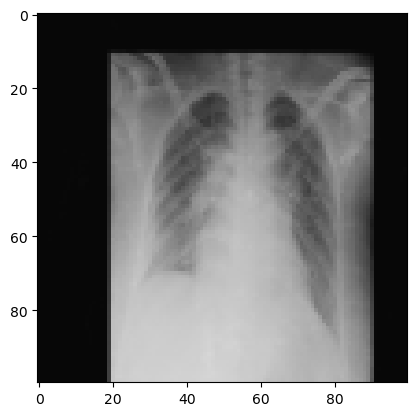

In [5]:
i = 4
plt.imshow(hhh[i])
print(np.shape(hhh[i]), np.max(hhh[i]), tamy[i])

In [6]:
X_treino, X_teste, Y_treino, Y_teste = train_test_split(hhh, tamy, test_size=0.2, random_state=50,shuffle=True)

In [7]:
tamy = 0 #list(Y_all).clear()
hhh.clear()

print(tamy, hhh)
print(np.shape(X_treino), np.shape(X_teste), np.shape(Y_treino), np.shape(Y_teste))

0 []
(8561, 100, 100, 3) (2141, 100, 100, 3) (8561,) (2141,)


In [8]:
start_time = time.time()
model_extract = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

features_treino = model_extract.predict(np.array(X_treino))
features_teste = model_extract.predict(np.array(X_teste))
print("--- %s seconds ---" % (time.time() - start_time))

67/67 [==============================] - 4s 55ms/step
--- 34.23599410057068 seconds ---


In [10]:
start_time = time.time()

#iniciando as listas
mae_por_fold = []
loss_por_fold = []
all_models=[]
all_loss=[]
all_mae=[]
all_vloss=[]
all_vmae=[]

#Dados de entrada
inputs = features_treino
targets = Y_treino

# escolher o numero de folds
num_folds = 5

# Validação cruzada
kfold = KFold(n_splits=num_folds, shuffle=True)
fold_no = 1
for train, test in kfold.split(inputs, targets):

    np.random.RandomState(10000) # Fixar o pseudo-random generator do numpy
    tf.random.set_seed(10000) # Fixar o pseudo-random generator do tensorflow

    model = Sequential()
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))

    opt = ke.optimizers.Adam( learning_rate=0.00001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False)
    #callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
    model.compile(optimizer= opt, loss='mse',metrics=['mae'])  # Compilando o modelo
    

    print('------------------------------------------------------------------------')
    print(f'Treinamento para o fold {fold_no} ...')
    
    # Fit data to model
    history = model.fit(inputs[train], targets[train],
              batch_size=10,
              #callbacks=[callback],
              epochs=100,
              validation_data=(inputs[test], targets[test]))

  
    mse, mae =  model.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score para o fold {fold_no}: {model.metrics_names[0]} de {mse}; {model.metrics_names[1]} de {mae}')
    mae_por_fold.append(mae) # aqui estamos criando uma lista com as accs dos 5 folds
    loss_por_fold.append(mse)    # aqui estamos criando uma lista com as loss dos 5 folds
    
   # Increase fold number
    fold_no = fold_no + 1
    
    
    all_models.append(model)
    
    all_vloss.append(history.history["val_loss"])
    all_vmae.append(history.history["val_mae"])
    all_loss.append(history.history["loss"])
    all_mae.append(history.history["mae"])
    
print("--- %s seconds ---" % (time.time() - start_time))

------------------------------------------------------------------------
Treinamento para o fold 1 ...
Epoch 1/100
685/685 [==============================] - 5s 6ms/step - loss: 2760.4641 - mae: 49.0552 - val_loss: 2596.4458 - val_mae: 47.5541
Epoch 2/100
685/685 [==============================] - 4s 5ms/step - loss: 2531.4177 - mae: 46.7866 - val_loss: 2350.6147 - val_mae: 45.0363
Epoch 3/100
685/685 [==============================] - 4s 6ms/step - loss: 2310.4551 - mae: 44.4321 - val_loss: 2095.3840 - val_mae: 42.1694
Epoch 4/100
685/685 [==============================] - 4s 6ms/step - loss: 2068.9634 - mae: 41.6116 - val_loss: 1820.5818 - val_mae: 38.7951
Epoch 5/100
685/685 [==============================] - 4s 6ms/step - loss: 1816.3312 - mae: 38.4179 - val_loss: 1565.9902 - val_mae: 35.3443
Epoch 6/100
685/685 [==============================] - 4s 6ms/step - loss: 1569.5640 - mae: 35.0094 - val_loss: 1334.7035 - val_mae: 31.9524
Epoch 7/100
685/685 [==============================

In [11]:
import pickle

# Salvar todas as variáveis em um arquivo pickle
with open("all_variables.pkl", "wb") as f:
    pickle.dump([all_models, all_vloss, all_vmae, all_loss, all_mae, mae_por_fold,loss_por_fold], f)

# # Carregar as variáveis a partir do arquivo pickle
# with open("all_variables.pkl", "rb") as f:
#     all_models, all_vloss, all_vmae, all_loss, all_mae, mae_por_fold,loss_por_fold = pickle.load(f)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......batch_normalization
.........vars
............0
............1
............2
............3
......batch_normalization_1
.........vars
............0
............1
............2
............3
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......flatten
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-03-29 13:35:36         4016
variables.h5                                   2023-03-29 13:35:36      4923160
metadata.json 

------------------------------------------------------------------------
Scores para cada um dos folds:
------------------------------------------------------------------------
> Fold 1 - Loss: 138.09884643554688 - mae: 9.288652420043945
------------------------------------------------------------------------
> Fold 2 - Loss: 141.87840270996094 - mae: 9.274538040161133
------------------------------------------------------------------------
> Fold 3 - Loss: 155.23426818847656 - mae: 9.787851333618164
------------------------------------------------------------------------
> Fold 4 - Loss: 139.64157104492188 - mae: 9.302092552185059
------------------------------------------------------------------------
> Fold 5 - Loss: 149.41453552246094 - mae: 9.586455345153809
------------------------------------------------------------------------
Média dos scores para todos os folds:
> mae: 9.447917938232422 (+- 0.20563971599372446)
> Loss: 144.85352478027343(+- 0.20563971599372446)
--------------

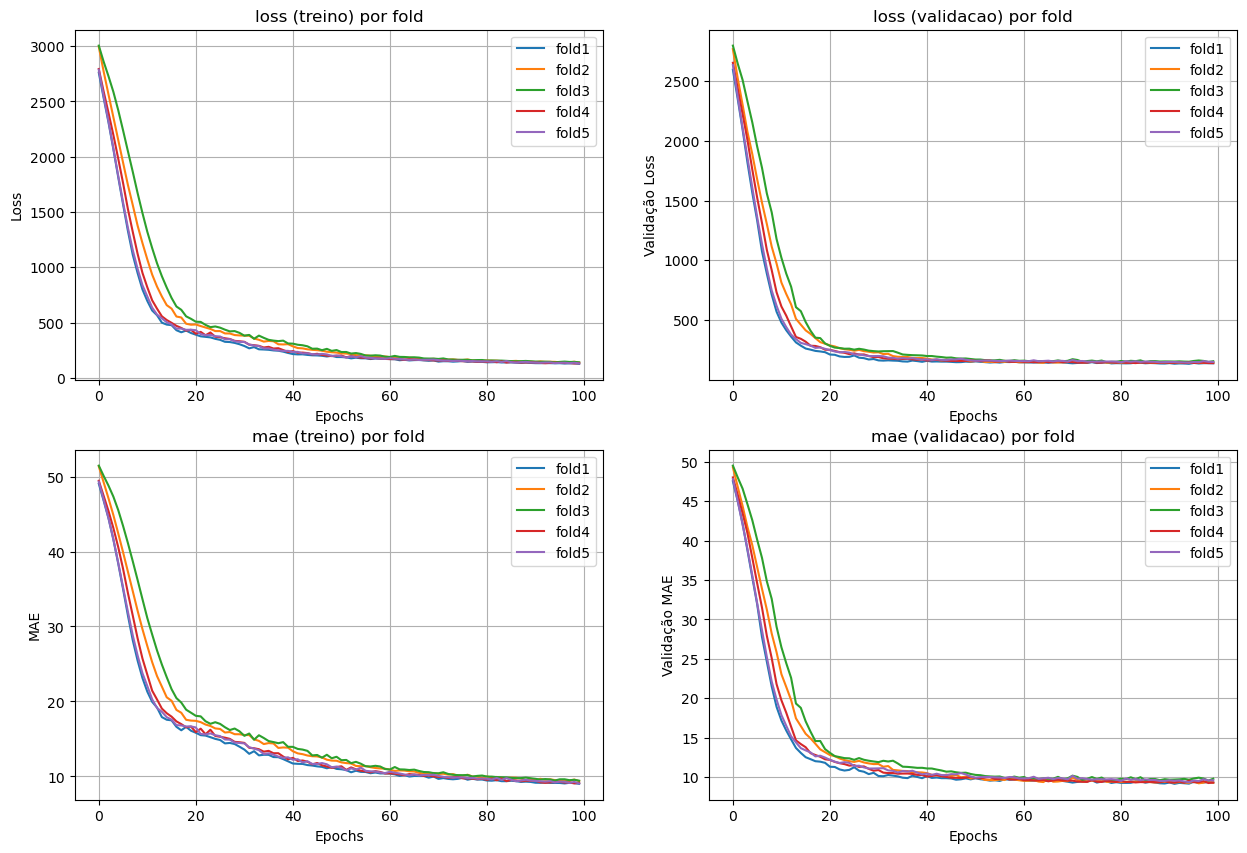

In [12]:
# Dados de Saida
print('------------------------------------------------------------------------')
print('Scores para cada um dos folds:')

for i in range(0, len(mae_por_fold)):
        print('------------------------------------------------------------------------')
        print(f'> Fold {i+1} - Loss: {loss_por_fold[i]} - mae: {mae_por_fold[i]}')
    
print('------------------------------------------------------------------------')
print('Média dos scores para todos os folds:')
print(f'> mae: {np.mean(mae_por_fold)} (+- {np.std(mae_por_fold)})')
print(f'> Loss: {np.mean(loss_por_fold)}(+- {np.std(mae_por_fold)})')
print('------------------------------------------------------------------------')
print(f'> Tamanho do conjunto de treinamento e conjunto de teste por fold: {(len(train), len(test))}')


fig, axs = plt.subplots(2, 2, figsize=(15,10))
for i in range(num_folds):
    axs[0, 0].plot(all_loss[i], label="fold"+str(i+1))
    axs[0, 0].set_title('loss (treino) por fold')
    axs[0, 0].legend(loc='upper right')
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].grid()

    axs[0, 1].plot(all_vloss[i], label="fold"+str(i+1))
    axs[0, 1].set_title('loss (validacao) por fold')
    axs[0, 1].legend(loc='upper right')
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('Validação Loss')
    axs[0, 1].grid()

    axs[1, 0].plot(all_mae[i], label="fold"+str(i+1))
    axs[1, 0].set_title('mae (treino) por fold')
    axs[1, 0].legend(loc='upper right')
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('MAE')
    axs[1, 0].grid()

    axs[1, 1].plot(all_vmae[i], label="fold"+str(i+1))
    axs[1, 1].set_title('mae (validacao) por fold')
    axs[1, 1].legend(loc='upper right')
    axs[1, 1].set_xlabel('Epochs')
    axs[1, 1].set_ylabel('Validação MAE')
    axs[1, 1].grid()

# plt.savefig('img0.png', bbox_inches='tight')

In [13]:
def smooth_curve(points, factor=0.7):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


In [14]:
smooth_vmae_history = []
smooth_mae_history = []
smooth_vloss_history = []
smooth_loss_history = []

for i in range(0,num_folds):
    VMae = smooth_curve(all_vmae[i][10:])
    Mae = smooth_curve(all_mae[i][10:])
    VLoss = smooth_curve(all_vloss[i][10:])
    Loss = smooth_curve(all_loss[i][10:])
    
    smooth_vmae_history.append(VMae)
    smooth_mae_history.append(Mae)
    smooth_vloss_history.append(VLoss)
    smooth_loss_history.append(Loss)

------------------------------------------------------------------------
Média dos scores para todos os folds:
> mae: 9.447917938232422 (+- 0.20563971599372446)
------------------------------------------------------------------------
> Tamanho do conjunto de treinamento e validação por fold: (6849, 1712)


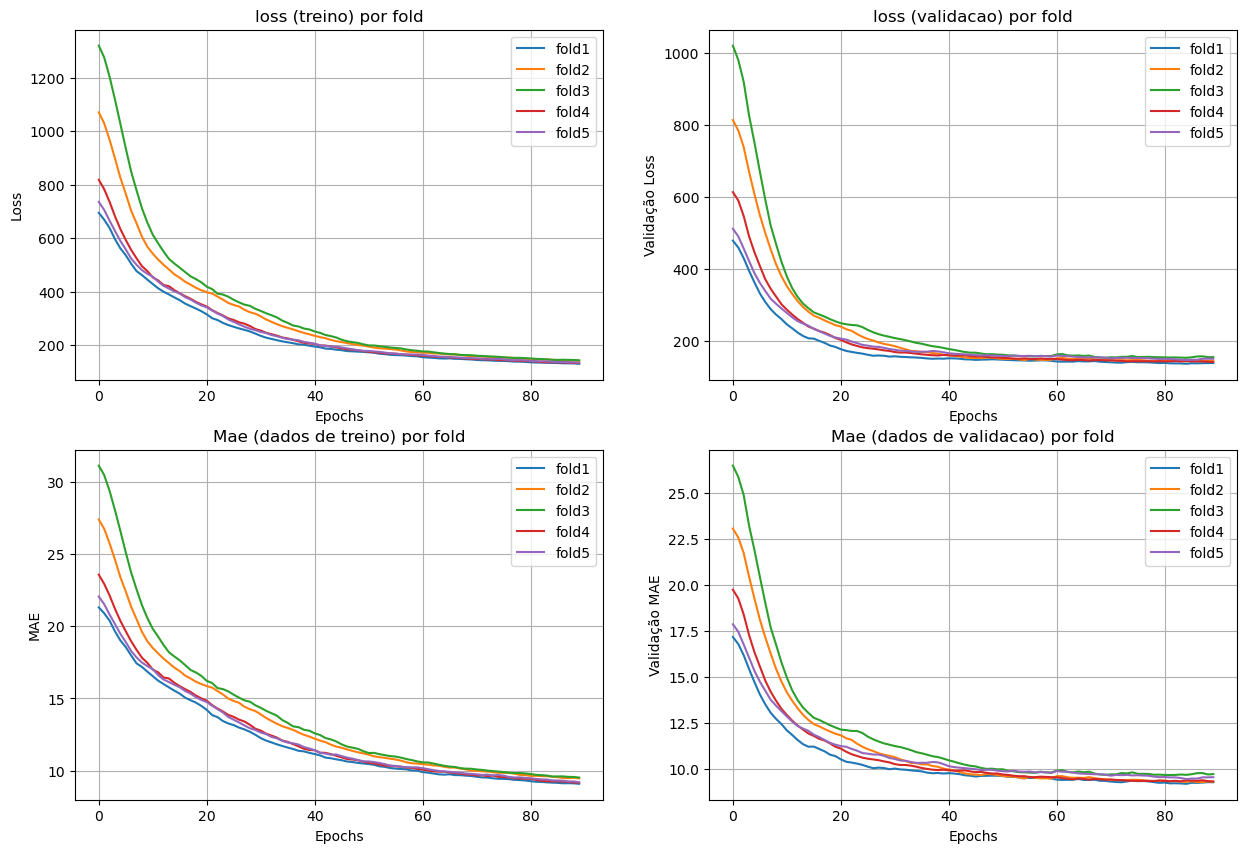

In [15]:
#print('------------------------------------------------------------------------')
#print('Scores para cada um dos folds:')

#for i in range(0, len(mae_por_fold)):
#        print('------------------------------------------------------------------------')
#        print(f'> Fold {i+1} - Loss: {loss_por_fold[i]} - mae: {mae_por_fold[i]}')
    
print('------------------------------------------------------------------------')
print('Média dos scores para todos os folds:')
print(f'> mae: {np.mean(mae_por_fold)} (+- {np.std(mae_por_fold)})')
#print(f'> Loss: {np.mean(loss_por_fold)}(+- {np.std(mae_por_fold)})')
print('------------------------------------------------------------------------')
print(f'> Tamanho do conjunto de treinamento e validação por fold: {(len(train), len(test))}')


fig, axs = plt.subplots(2, 2, figsize=(15,10))
for i in range(num_folds):
    axs[0, 0].plot(smooth_loss_history[i],label="fold"+str(i+1))
    axs[0, 0].set_title('loss (treino) por fold')
    axs[0, 0].legend(loc='upper right')
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].grid()
    axs[0, 1].plot(smooth_vloss_history[i],label="fold"+str(i+1))
    axs[0, 1].set_title('loss (validacao) por fold')
    axs[0, 1].legend(loc='upper right')
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('Validação Loss')
    axs[0, 1].grid()
    axs[1, 0].plot(smooth_mae_history[i],label="fold"+str(i+1))
    axs[1, 0].set_title('Mae (dados de treino) por fold')
    axs[1, 0].legend(loc='upper right')
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('MAE')
    axs[1, 0].grid()
    axs[1, 1].plot(smooth_vmae_history[i],label="fold"+str(i+1))
    axs[1, 1].set_title('Mae (dados de validacao) por fold')
    axs[1, 1].legend(loc='upper right')
    axs[1, 1].set_xlabel('Epochs')
    axs[1, 1].set_ylabel('Validação MAE')
    axs[1, 1].grid()      
# plt.savefig('img1.png', bbox_inches='tight');

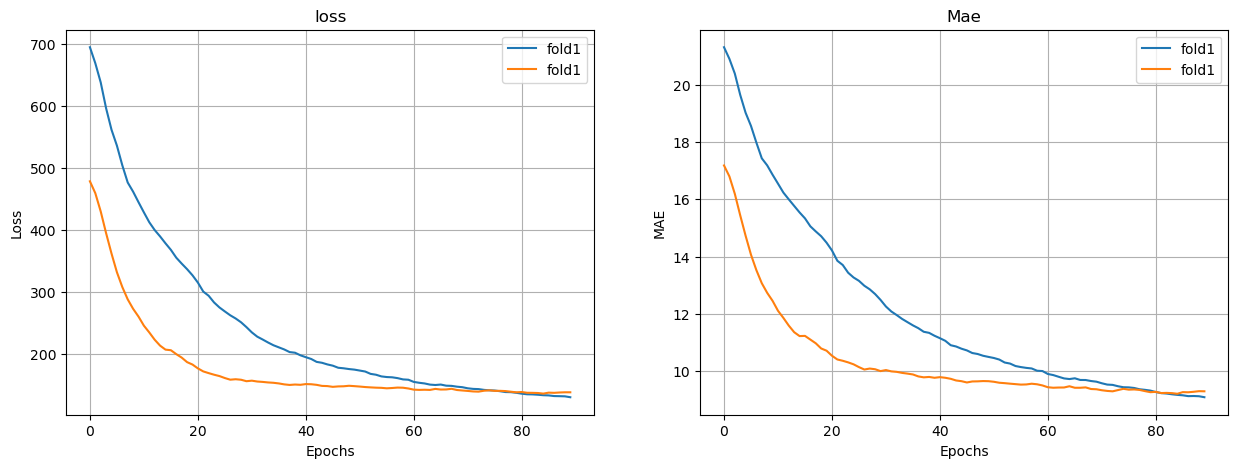

In [16]:
# Melhor Fold
fold = 1
i = fold - 1
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].plot(smooth_loss_history[i],label="fold"+str(i+1))
axs[0].plot(smooth_vloss_history[i],label="fold"+str(i+1))
axs[0].set_title('loss')
axs[0].legend(loc='upper right')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].grid()
axs[1].plot(smooth_mae_history[i],label="fold"+str(i+1))
axs[1].plot(smooth_vmae_history[i],label="fold"+str(i+1))
axs[1].set_title('Mae')
axs[1].legend(loc='upper right')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('MAE')
axs[1].grid()

In [17]:
fold = 1
Ypred_treino=all_models[fold-1].predict(np.array(features_treino))
Ypred_teste=all_models[fold-1].predict(np.array(features_teste))

67/67 [==============================] - 0s 2ms/step


In [19]:
#salvar o modelo do melhor fold
fold = 1
all_models[fold-1].save('model1_melhor_fold.h5')

In [18]:
from sklearn.metrics import mean_absolute_error

print('MAE treino = ', mean_absolute_error(Ypred_treino, Y_treino))
print('MAE teste = ', mean_absolute_error(Ypred_teste, Y_teste))

MAE treino =  7.320256546019617
MAE teste =  9.42292751034305


In [ ]:
Tabela_teste = pd.read_csv('/kaggle/input/spr-x-ray-age/sample_submission_age.csv',sep = ',',engine = 'python')
display(Tabela_teste)